In [1]:
import sys
sys.path.append('..')
import pandas as pd
from adat.models.classification_model import LogisticRegressionOnTfIdf
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
train_data = pd.read_csv('../data/ai_academy_data/train.csv')
test_data = pd.read_csv('../data/ai_academy_data/test.csv')

In [3]:
train_data

,sequences,labels
0,bin3_trans34 bin3_trans34 bin1_trans1 bin1_tra...,1
1,bin3_trans144 bin1_trans3 bin2_trans3 bin0_tra...,3
2,bin1_trans3 bin4_trans1 bin4_trans1 bin2_trans...,1
3,bin1_trans4 bin1_trans3 bin0_trans1 bin1_trans...,2
4,bin2_trans2 bin4_trans1 bin2_trans25 bin1_tran...,3
...,...,...
199995,bin4_trans37 bin2_trans82 bin2_trans24 bin4_tr...,2
199996,bin4_trans11 bin4_trans4 bin1_trans25 bin1_tra...,3
199997,bin2_trans37 bin3_trans106 bin2_trans37 bin3_t...,1
199998,bin3_trans1 bin0_trans9 bin2_trans4 bin0_trans...,1


In [4]:
train_x = train_data.sequences.values
train_y = train_data.labels.values

test_x = test_data.sequences.values
test_y = test_data.labels.values

In [5]:
model = LogisticRegressionOnTfIdf()

In [6]:
model.fit(train_x, train_y)

In [7]:
import joblib

In [9]:
joblib.dump(model, '../results/ai_academy_data/logit_tfidf.model')

['../results/ai_academy_data/logit_tfidf.model']

In [10]:
probs = model.predict(test_x)

In [31]:
auc = roc_auc_score(y_true=test_y, y_score=probs, multi_class='ovr', average='macro')
print(f'ROC AUC = {auc}')

ROC AUC = 0.7049430872156314


array([1, 1, 3, ..., 3, 2, 0])

In [11]:
import numpy as np

In [23]:
acc = (test_y == probs.argmax(axis=1)).mean()

print(f'Accuracy = {acc}')

Accuracy = 0.4359387207445905


In [13]:
acc = (test_y == np.random.choice(test_y, len(test_y), replace=False)).mean()

print(f'Accuracy random baseline = {acc}')

Accuracy random baseline = 0.2481673969903869


# Adversarial MCMC sampler vs Random sampler

In [14]:
original = pd.read_csv('../data/ai_academy_data/random_1000.csv')

In [15]:
output_random = pd.read_csv('../results/ai_academy_data/random_results/results.csv')
output_mcmc = pd.read_csv('../results/ai_academy_data/mcmc_results/results.csv')
output_gradient = pd.read_csv('../results/ai_academy_data/gradient_results/results.csv')

In [17]:
output_random = output_random.join(original)
output_mcmc = output_mcmc.join(original)
output_gradient = output_gradient.join(original)

In [19]:
output_gradient[['sequences', 'generated_sequence', 'labels']].to_csv('../results/ai_academy_data/gradient_results/results_for_eval.csv')

In [93]:
from adat.utils import calculate_wer

In [94]:
def calculate_nad(probs_orig, probs_gen, seqs_orig, seqs_gen):
    wers = np.array([calculate_wer(seqs_orig[i], seqs_gen[i]) for i in range(len(seqs_orig))])
    errs = (probs_orig.argmax(axis=1) != probs_gen.argmax(axis=1))
    return np.mean(errs/(1e-6 + wers))

In [95]:
def calculate_metrics(model, labels, seqs_orig, seqs_gen):
    probs_orig = model.predict(seqs_orig)
    probs_gen = model.predict(seqs_gen)
    acc_orig = (labels == probs_orig.argmax(axis=1)).mean()
    acc_gen = (labels == probs_gen.argmax(axis=1)).mean()
    proba_orig = probs_orig[np.arange(len(labels)), labels]
    proba_gen = probs_gen[np.arange(len(labels)), labels]
    metrics = {}
    metrics['accuracy_drop'] = acc_orig - acc_gen
    metrics['probability_drop'] = (proba_orig - proba_gen).mean() 
    metrics['WER'] = np.mean([calculate_wer(seqs_orig[i], seqs_gen[i]) 
                              for i in range(len(seqs_orig))])
    metrics['NAD'] = calculate_nad(probs_orig, probs_gen, seqs_orig, seqs_gen)
    return metrics

In [96]:
calculate_metrics(model,
                  output_random['labels'].values,
                  output_random['sequences'].values,
                  output_random['generated_sequence'].values)

{'accuracy_drop': 0.20100000000000007,
 'probability_drop': 0.08007158437985157,
 'WER': 2.033,
 'NAD': 0.18489311223573912}

In [97]:
calculate_metrics(model,
                  output_mcmc['labels'].values,
                  output_mcmc['sequences'].values,
                  output_mcmc['generated_sequence'].values)

{'accuracy_drop': 0.14700000000000008,
 'probability_drop': 0.06780377937668718,
 'WER': 1.597,
 'NAD': 0.11396344511351732}

In [98]:
calculate_metrics(model,
                  output_gradient['labels'].values,
                  output_gradient['sequences'].values,
                  output_gradient['generated_sequence'].values)

{'accuracy_drop': 0.30700000000000005,
 'probability_drop': 0.16628604597012447,
 'WER': 3.054,
 'NAD': 0.12520621011462696}

In [158]:
original = pd.read_csv('../data/ai_academy_data/random_1000.csv')
#original = pd.read_csv('../data/ai_academy_data/random100.csv')

In [159]:
output_random = pd.read_csv('../results/ai_academy_data/random_results/results.csv')
output_mcmc = pd.read_csv('../results/ai_academy_data/mcmc_results/results.csv')

In [160]:
output_random = output_random.join(original)
output_mcmc = output_mcmc.join(original)

In [161]:
calculate_metrics(model,
                  output_random['labels'].values,
                  output_random['sequences'].values,
                  output_random['generated_sequence'].values)

{'accuracy_drop': 0.29500000000000004,
 'probability_drop': 0.12409497409847296,
 'WER': 3.101,
 'NAD': 0.18919749623140195}

In [162]:
calculate_metrics(model,
                  output_mcmc['labels'].values,
                  output_mcmc['sequences'].values,
                  output_mcmc['generated_sequence'].values)

{'accuracy_drop': 0.31200000000000006,
 'probability_drop': 0.13482185356870413,
 'WER': 3.156,
 'NAD': 0.1798098056557804}

In [53]:
calculate_wer(output_gradient.iloc[0]['sequences'], output_gradient.iloc[0]['generated_sequence'])

7

In [54]:
probs_orig = model.predict(output_gradient['sequences'].values)
probs_gen = model.predict(output_gradient['generated_sequence'].values)

In [58]:
acc_orig = (output_gradient['labels'].values == probs_orig.argmax(axis=1)).mean()
acc_gen = (output_gradient['labels'].values == probs_gen.argmax(axis=1)).mean()

In [60]:
acc_orig - acc_gen # accuracy drop

0.30700000000000005

In [65]:
proba_orig = probs_orig[np.arange(len(output_gradient['labels'].values)), output_gradient['labels'].values]
proba_gen = probs_gen[np.arange(len(output_gradient['labels'].values)), output_gradient['labels'].values]

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([267., 149., 168., 121., 122.,  90.,  45.,  21.,  14.,   3.]),
 array([0.00140359, 0.0806633 , 0.15992301, 0.23918272, 0.31844243,
        0.39770214, 0.47696186, 0.55622157, 0.63548128, 0.71474099,
        0.7940007 ]),
 <a list of 10 Patch objects>)

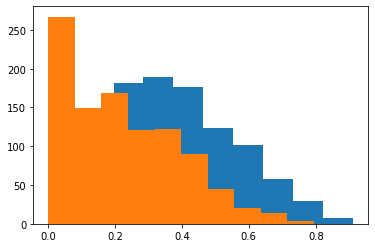

In [70]:
plt.hist(proba_orig)
plt.hist(proba_gen)

In [72]:
(proba_orig - proba_gen).mean() # proba drop

0.16628604597012447

In [83]:
calculate_nad(probs_orig, probs_gen, 
              output_gradient['sequences'].values, output_gradient['generated_sequence'].values)

0.12520621011462696

In [65]:
def get_results(output, test_y, generated, original):
    num_generated_so_far = generated.shape[0]

    adversarial_probs = model.predict(generated)

    print(f'Average WER = {output.wer.mean()}\nAverage BLEU = {output.bleu.mean()}\n')
    print(f'Naive ROC AUC = {naive_auc}\nNaive Accuracy = {naive_acc}\n')

    non_adversarial_probs = model.predict(original)
    adv_auc = roc_auc_score(y_true=test_y[:num_generated_so_far], y_score=non_adversarial_probs[:, 1])
    print(f'Non-Adversarial ROC AUC = {adv_auc}')
    adv_acc = (test_y[:num_generated_so_far] == non_adversarial_probs.argmax(axis=1)).mean()
    print(f'Non-Adversarial Accuracy = {adv_acc}\n')

    adv_auc = roc_auc_score(y_true=test_y[:num_generated_so_far], y_score=adversarial_probs[:, 1])
    print(f'Adversarial ROC AUC = {adv_auc}')
    adv_acc = (test_y[:num_generated_so_far] == adversarial_probs.argmax(axis=1)).mean()
    print(f'Adversarial Accuracy = {adv_acc}')

In [66]:
print('>>> MCMC\n')
get_results(output, test_y, generated, original)

>>> MCMC

Average WER = 1.8081227563876963
Average BLEU = 0.8201734764653238

Naive ROC AUC = 0.5
Naive Accuracy = 0.554656155416344

Non-Adversarial ROC AUC = 0.7425382836750724
Non-Adversarial Accuracy = 0.6852959808545084

Adversarial ROC AUC = 0.6136349112938747
Adversarial Accuracy = 0.5886534806785387


In [67]:
print('>>> Random\n')
get_results(output_rand, test_y, generated_rand, original_rand)

>>> Random

Average WER = 1.4975012317871472
Average BLEU = 0.8514050227449653

Naive ROC AUC = 0.5
Naive Accuracy = 0.554656155416344

Non-Adversarial ROC AUC = 0.7425382836750724
Non-Adversarial Accuracy = 0.6852959808545084

Adversarial ROC AUC = 0.6678953766750988
Adversarial Accuracy = 0.6265221369747308


In [68]:
print('>>> Hotflip\n')
get_results(output_hotflip, test_y, generated_hotflip, original_hotflip)

>>> Hotflip

Average WER = 6.903357499824031
Average BLEU = 0.2775505447367772

Naive ROC AUC = 0.5
Naive Accuracy = 0.554656155416344

Non-Adversarial ROC AUC = 0.7425382836750724
Non-Adversarial Accuracy = 0.6852959808545084

Adversarial ROC AUC = 0.5762124032929536
Adversarial Accuracy = 0.60660237910889
